In [1]:
import pickle
import numpy as np
import torchode

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family']='serif'

from tqdm.auto import tqdm

In [3]:
log_paths = [
    "g_0_1/log_hist.pkl",
    "g_5_5/log_hist.pkl",
    "g_10_10/log_hist.pkl",
]

logs = []

for path in log_paths:
    with open(path, 'rb') as file:
        logs.append(pickle.load(file))

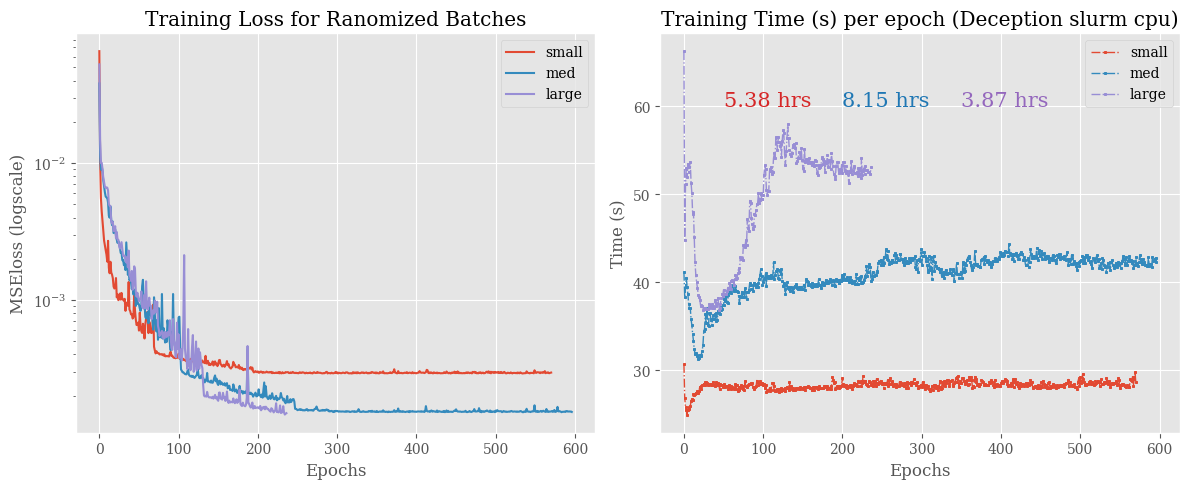

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

bounds = ["small", "med", "large"]
for idx, log in enumerate(logs):
    lab = bounds[idx]
    ax1.plot(log["losses"], label = lab )
    ax1.set_yscale("log")
    ax1.set_title("Training Loss for Ranomized Batches")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSEloss (logscale)")
    ax1.legend()

    tot_time = np.sum(log['times'])
    x_text = [50, 200, 350]
    text_colors = ["tab:red", "tab:blue", "tab:purple"]
    ax2.text(x_text[idx],60, f"{tot_time / (60*50):.2f} hrs", c=text_colors[idx],size=15)
    # print(tot_time / (60*60))
    ax2.plot(
        np.arange(len(log['times'])), log['times'],
        linestyle='-.', lw=1,          
        marker='+', markersize=1, markeredgewidth=2,  
        label=lab
    )
    ax2.set_title("Training Time (s) per epoch (Deception slurm cpu)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Time (s)")
    ax2.legend()

plt.tight_layout()
plt.show()

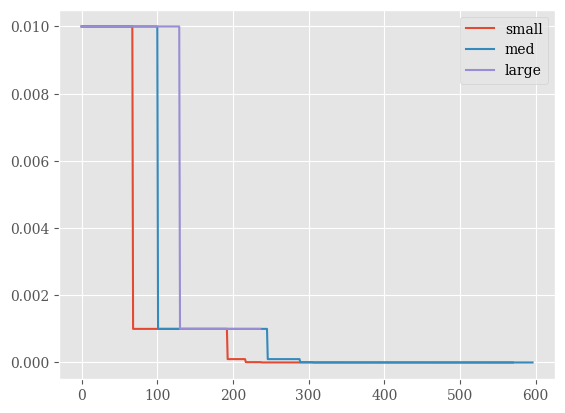

In [13]:
for idx, log in enumerate(logs):
    lab = bounds[idx]
    plt.plot(log['lr_hist'],label=lab)

plt.legend()
plt.show()

# Steady states

In [43]:
from scipy.optimize import root as sp_root
import torch
from stabnode.node import (
    FeluSigmoidMLP,
    GeluSigmoidMLP,
    StabNODE
)
device='cpu'

In [113]:
model_path = "g_5_5/model_opt_states.pt"

f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=-5, upper_bound=5)
model = StabNODE(f,g).to(device)

config = torch.load(model_path, map_location=device, weights_only=False)
f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])

g_eval = g.eval()

In [114]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)

x0 = np.array([0.5,0.5])

In [115]:
Z1 = np.zeros(shape=(len(p_vals),len(v_vals)))
Z2 = np.zeros(shape=(len(p_vals),len(v_vals)))

In [116]:
fail_count = 0
tol = 1e-9
fail_x = []
fail_y = []
resid_norm = []
resid_norm_fail = []
for i, pi in enumerate(tqdm(p_vals)):
    for j, vj in enumerate(v_vals):

        def obj(x):
            u = torch.tensor([pi,vj],dtype=torch.float32)
            x_torch = torch.tensor(x,dtype=torch.float32)
            with torch.no_grad():
                xi = g_eval(x_torch,u).numpy()
            return x - xi
        
        sol = sp_root(obj,x0,method='hybr')
        # if not sol.success:
        #     sol = sp_root(obj, np.array([0.1,0.9]),method='hybr')
        # if not sol.success:
        #     sol = sp_root(obj, np.array([0.9,0.9]),method='hybr')
        # if not sol.success:
        #     sol = sp_root(obj, np.array([0.2,0.2]),method='hybr')
        if not sol.success:
            if np.linalg.norm(sol.fun) > tol:
                fail_x.append(j)
                fail_y.append(i)
                resid_norm_fail.append(np.linalg.norm(sol.fun))
                fail_count +=1
            # print(i,j)
        resid_norm.append(np.linalg.norm(sol.fun))
        x0 = sol.x
        Z1[i,j] = sol.x[0]
        Z2[i,j] = sol.x[1]


  0%|          | 0/101 [00:00<?, ?it/s]

In [117]:
# sol

In [118]:
fail_count

562

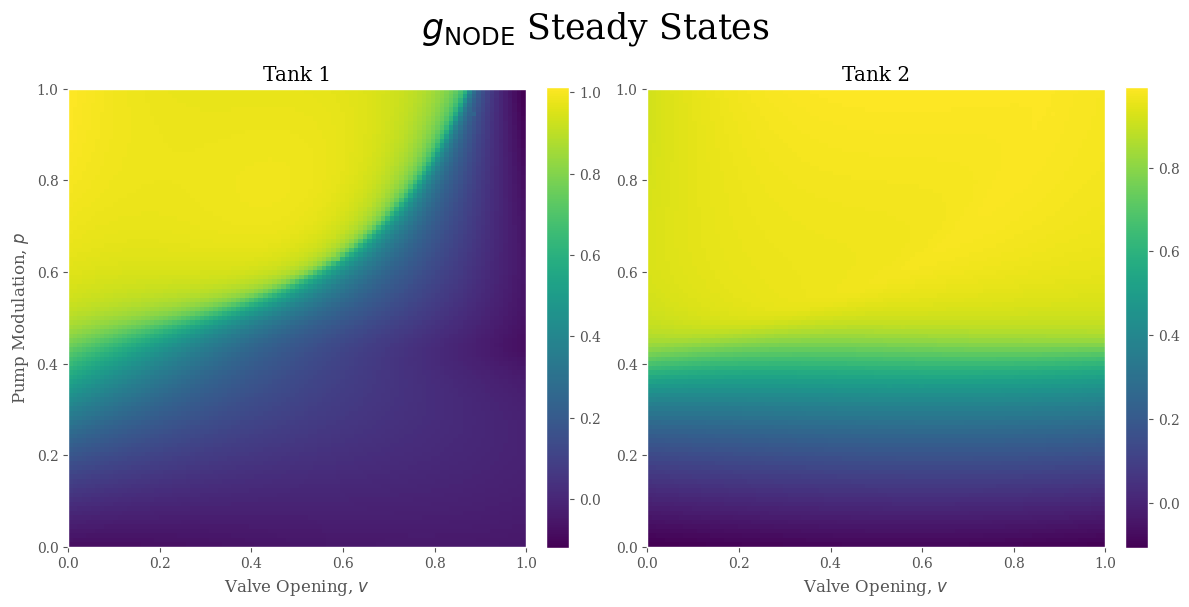

In [120]:
show_fail = False
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

im1 = ax1.imshow(Z1,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
if show_fail:
    ax1.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel(r"Pump Modulation, $p$")
ax1.set_xlabel(r"Valve Opening, $v$")
ax1.set_title("Tank 1")

im2 = ax2.imshow(Z2,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
if show_fail:
    ax2.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel(r"Valve Opening, $v$")
ax2.set_title("Tank 2")


ax1.grid(False)
ax2.grid(False)

plt.suptitle(r"$g_{\text{NODE}}$ Steady States",size=25)
plt.tight_layout()
plt.show()


In [125]:
from stabnode.utils import _load_loop_wrapper
from scipy.integrate import solve_ivp as sp_solve_ivp
from data.tanks import two_tank_system

In [126]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)


x0 = [0.5,0.5]

Z1_true = np.zeros((len(p_vals),len(v_vals)))
Z2_true = np.zeros((len(p_vals),len(v_vals)))

wrapper1 = _load_loop_wrapper(True)
wrapper2 = _load_loop_wrapper(False)
for i, pi in enumerate(wrapper1(p_vals)):
    for j, vj in enumerate(wrapper2(v_vals)):
        t_max = 300
        x0 = [0.5,0.5]
        u = np.array([pi,vj])
        sol = sp_solve_ivp(
            two_tank_system,
            t_span = [0,t_max],
            y0 = np.array(x0),
            t_eval= np.linspace(0,t_max, 501),
            args =(u,)
        )
        x1, x2 = sol.y[:,-1]
        Z1_true[i,j] = x1
        Z2_true[i,j] = x2

  0%|          | 0/101 [00:00<?, ?it/s]

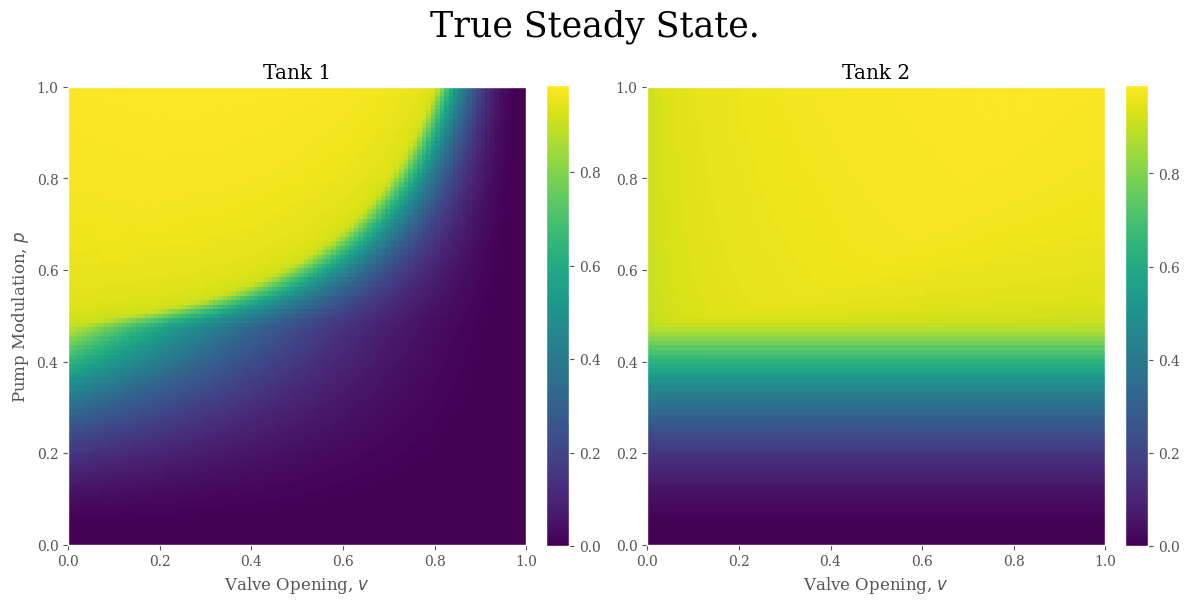

In [128]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

im1 = ax1.imshow(Z1_true,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
# ax1.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel(r"Pump Modulation, $p$")
ax1.set_xlabel(r"Valve Opening, $v$")
ax1.set_title("Tank 1")

im2 = ax2.imshow(Z2_true,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
# ax2.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel(r"Valve Opening, $v$")
ax2.set_title("Tank 2")


ax1.grid(False)
ax2.grid(False)


plt.suptitle(f"True Steady State.",size=25)
plt.tight_layout()
plt.show()

In [129]:
Z1_err = np.abs(Z1-Z1_true)
Z2_err = np.abs(Z2-Z2_true)

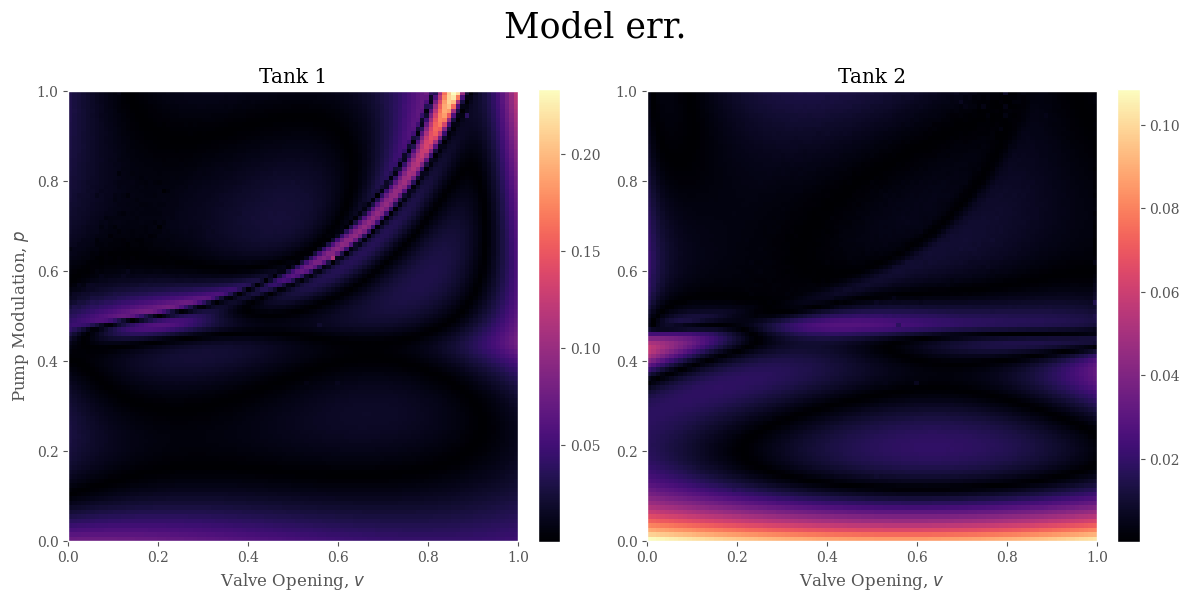

In [134]:
cmap = 'magma'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

im1 = ax1.imshow(Z1_err,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],cmap=cmap)
# ax1.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel(r"Pump Modulation, $p$")
ax1.set_xlabel(r"Valve Opening, $v$")
ax1.set_title("Tank 1")

im2 = ax2.imshow(Z2_err,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],cmap=cmap)
# ax2.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel(r"Valve Opening, $v$")
ax2.set_title("Tank 2")


ax1.grid(False)
ax2.grid(False)


plt.suptitle(f"Model err.",size=25)
plt.tight_layout()
plt.show()

(0.0, 1.0)


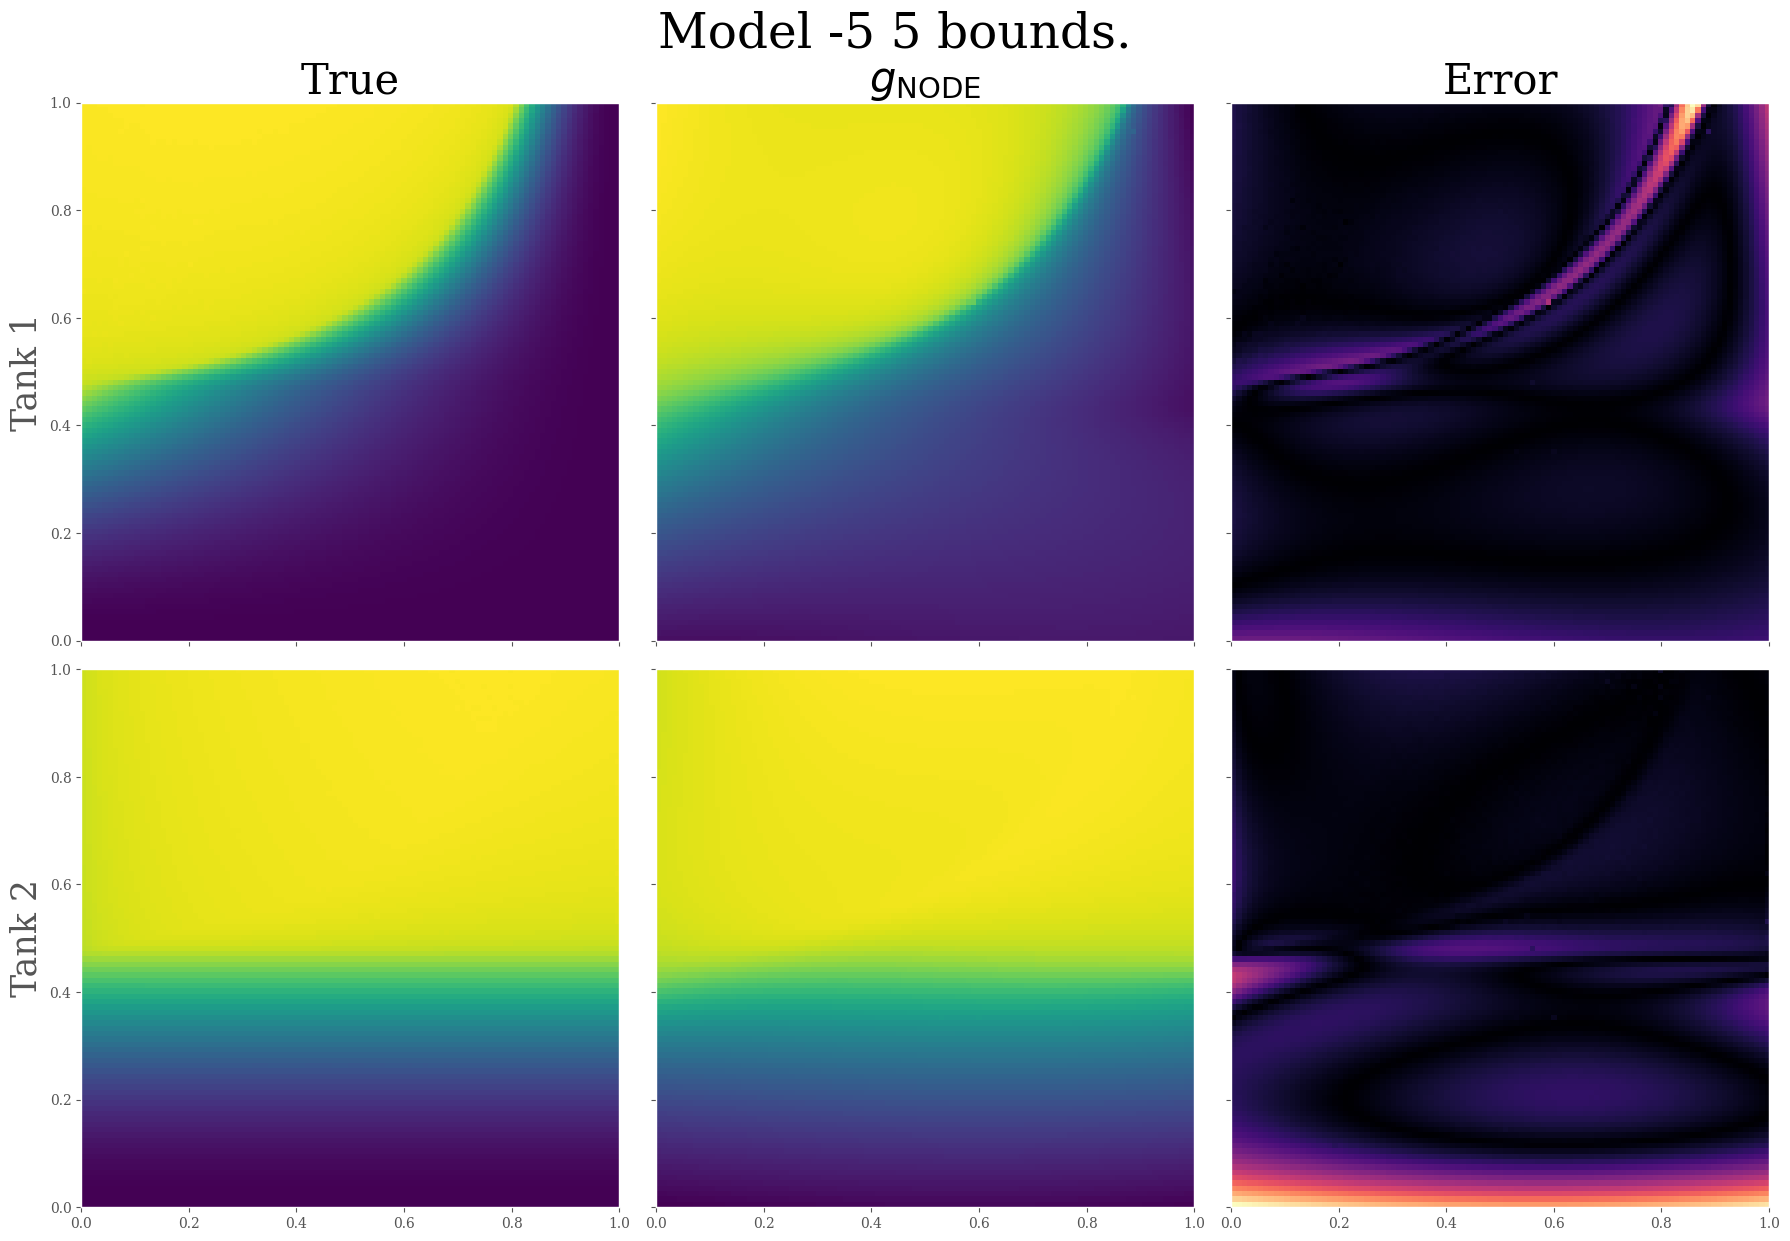

In [136]:
cmap='magma'
title_size = 30
fig, axes = plt.subplots(2,3, figsize=(18,12),sharex=True, sharey=True)
axs = axes.flatten()

axs[0].imshow(Z1_true,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
print(axs[0].get_ylim())
axs[1].imshow(Z1,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
im2 = axs[2].imshow(Z1_err,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],cmap=cmap)
# cbar2 = fig.colorbar(im2,ax=axs[2],fraction=0.046,pad=0.04)

axs[3].imshow(Z2_true,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
axs[4].imshow(Z2,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
im5 = axs[5].imshow(Z2_err,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]],cmap=cmap)
# cbar5 = fig.colorbar(im5,ax=axs[5],fraction=0.046,pad=0.04)

for ax in axs:
    ax.grid(False)

axs[0].set_title("True",size=title_size)
axs[1].set_title(r"$g_{\text{NODE}}$",size=title_size)
axs[2].set_title("Error",size=title_size)

axs[0].set_ylabel("Tank 1",size=25, rotation=90)
axs[3].set_ylabel("Tank 2",size=25,rotation=90)

plt.tight_layout()
plt.suptitle(f"Model -5 5 bounds.",size=35,y=1.03)
plt.show()


# control

In [137]:
def g_iter(x, u, max_iter):
    for _ in range(max_iter):
        x = g_eval(x, u)
    return x

def control_resid(u, x0, x1, max_iter=10):
    xi = g_iter(x0, u, max_iter)
    return x1 - xi

def control_policy(u0, x0, x1, eta, gd_steps, max_iter=10):
    u = u0.clone().detach().requires_grad_(True)
    resid_hist = []
    grad_norms = []

    for _ in range(gd_steps):
        if u.grad is not None:
            u.grad.zero_()

        resid = torch.sum(control_resid(u, x0, x1, max_iter=max_iter)**2)
        resid_hist.append(resid.item())

        resid.backward()

        with torch.no_grad():
            grad = u.grad
            grad_norms.append(torch.linalg.norm(grad).item())
            u -= eta * grad
            
        u = u.detach().requires_grad_(True)

    return u, resid_hist, grad_norms

In [138]:
x1_lin  = np.linspace(0,1,101)
x2_lin = np.linspace(0,1,101)

X1, X2 = np.meshgrid(x1_lin,x2_lin)

In [142]:
x0 = torch.tensor([0.5,0.5],dtype=torch.float32,)
u0 = torch.tensor([0.5,0.5],dtype=torch.float32,requires_grad=True)

In [143]:

X_target = np.vstack((X1.flatten(), X2.flatten())).T
X_target = torch.tensor(X_target, dtype=torch.float32)
X_init = x0.expand(X_target.shape)
U_init = u0.detach().expand(X_target.shape)
U_init = torch.tensor([0.8,0.8],dtype=torch.float32).expand(X_target.shape)

In [144]:
U_control,resid_hist, grad_norm_hist = control_policy(U_init, X_init, X_target, eta=1e-2, gd_steps=2000)

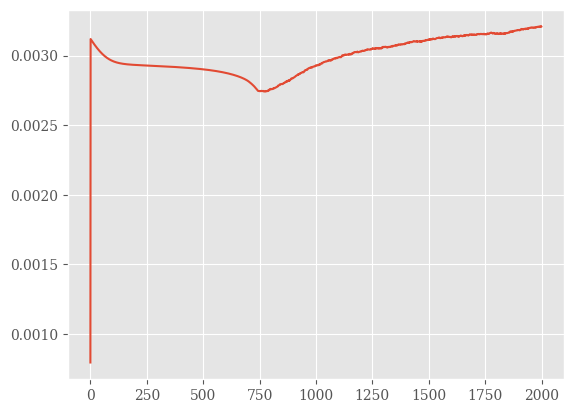

In [145]:
plt.plot(np.array(resid_hist) / len(U_control)**2)
plt.show()

In [146]:
U_control_clamp = torch.clamp(U_control.detach(),0,1)

In [147]:
stop = 0
t_max=300
n_colloc=501

X_pred = []
for ui, xi in tqdm(zip(U_control_clamp, X_init),total=len(U_control)):
    # if stop > 20:
    #     # break
    #     pass
    sol = sp_solve_ivp(
        two_tank_system,
        t_span = [0,t_max],
        y0 = np.array(xi),
        t_eval = np.linspace(0,t_max, n_colloc),
        args = (ui.detach().numpy(),)
    )
    X_pred.append(sol.y[:,-1])
    # stop +=1
X_pred = np.array(X_pred)

  0%|          | 0/10201 [00:00<?, ?it/s]

In [148]:
Z1_pred = X_pred[:,0]
Z2_pred = X_pred[:,1]

Z1_target = X_target[:,0].numpy()
Z2_target = X_target[:,1].numpy()

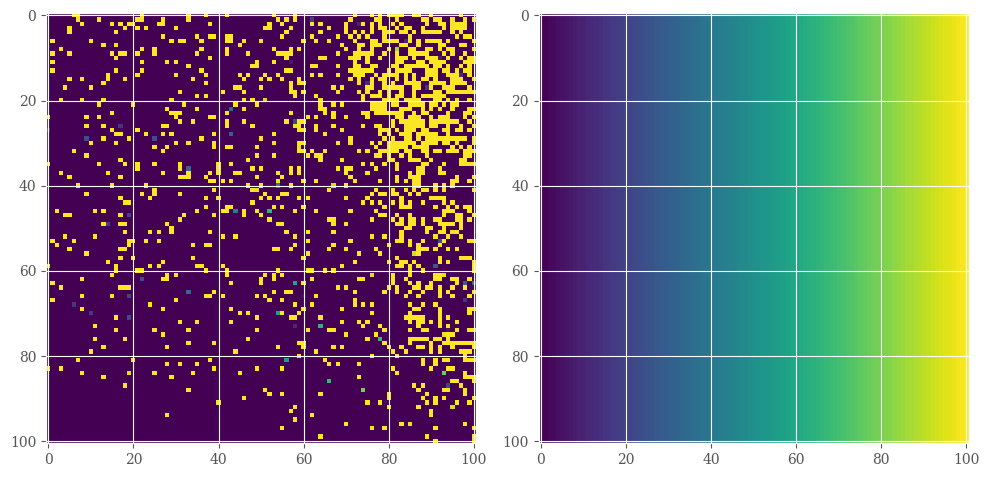

In [149]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(Z1_pred.reshape(101,101))
ax2.imshow(Z1_target.reshape(101,101))

plt.tight_layout()
plt.show()

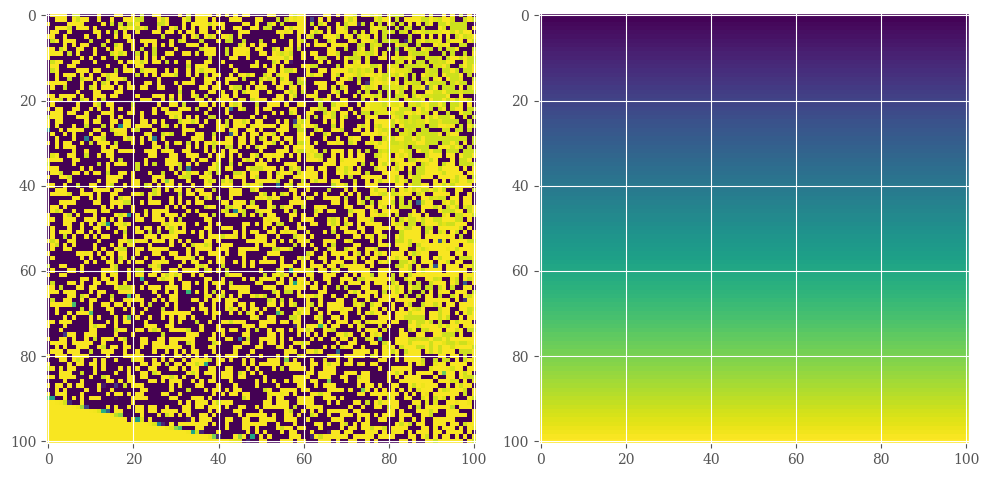

In [150]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(Z2_pred.reshape(101,101))
ax2.imshow(Z2_target.reshape(101,101))

plt.tight_layout()
plt.show()

## misc attempt at finding steadystates via iteratation

In [99]:
u=torch.tensor([pi, vj],dtype=torch.float32)
x0_torch = torch.tensor(x0,dtype=torch.float32)
g_iter(x0_torch,u,max_iter=10).detach()

tensor([-0.0887,  0.8704])

array([-0.12031355,  0.97848293])

In [109]:
x0 = np.array([0.5,0.5])
x0 = torch.tensor(x0,dtype=torch.float32)
max_iter=50
fail_count = 0
tol = 1e-9
fail_x = []
fail_y = []
resid_norm = []
resid_norm_fail = []
for i, pi in enumerate(tqdm(p_vals)):
    for j, vj in enumerate(v_vals):

        ui = torch.tensor([pi,vj],dtype=torch.float32)

        with torch.no_grad():
            x0 = g_iter(x0, ui,max_iter=max_iter)



        # x0 = sol.x
        Z1[i,j] = x0[0].item()
        Z2[i,j] = x0[1].item()


/var/folders/9x/8bf0hckd1b122g3zlj_z9c1w0000gp/T/ipykernel_26565/3059893476.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0,dtype=torch.float32)


  0%|          | 0/101 [00:00<?, ?it/s]

In [111]:
Z1_clip= np.clip(Z1,0,1)
Z2_clip = np.clip(Z1,0,1)

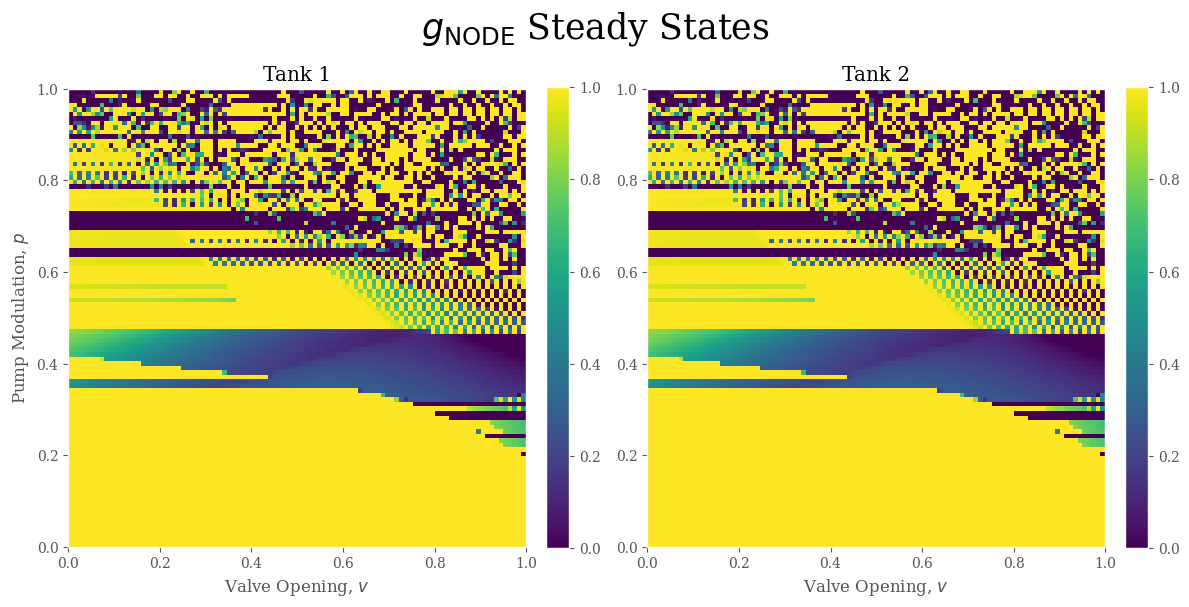

In [112]:
show_fail = False
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

im1 = ax1.imshow(Z1_clip,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
if show_fail:
    ax1.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar1 = fig.colorbar(im1,ax=ax1,fraction=0.046,pad=0.04)
ax1.set_ylabel(r"Pump Modulation, $p$")
ax1.set_xlabel(r"Valve Opening, $v$")
ax1.set_title("Tank 1")

im2 = ax2.imshow(Z2_clip,origin='lower',extent=[v_vals[0],v_vals[-1],p_vals[0],p_vals[-1]])
if show_fail:
    ax2.scatter(v_vals[fail_x], p_vals[fail_y],marker='x')
cbar2 = fig.colorbar(im2,ax=ax2,fraction=0.046,pad=0.04)
ax2.set_xlabel(r"Valve Opening, $v$")
ax2.set_title("Tank 2")


ax1.grid(False)
ax2.grid(False)

plt.suptitle(r"$g_{\text{NODE}}$ Steady States",size=25)
plt.tight_layout()
plt.show()
